In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from intfeat import StrumLiouvilleTransformer, StrumLiouvilleColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import KBinsDiscretizer, SplineTransformer
from typing import Literal
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Test on a synthetic dataset

In [3]:
def get_powerlaw_weights(max_val=1000, alpha=1., beta=1.):
    xs = np.arange(max_val)
    ws = np.power(alpha + xs, -beta)
    return ws / ws.sum()

In [4]:
def choose_features(size, max_val=1000, alpha=1., beta=1.):
    weights = get_powerlaw_weights(max_val, alpha, beta)
    return np.random.choice(np.arange(max_val), size=size, p=weights)

In [5]:
def func(X):
    m, n = X.shape
    lg = np.asinh(X * np.arange(1, 1 + n))

    y = np.zeros(m)
    w = np.linspace(-1, 1, n)
    b = np.linspace(-np.pi, np.pi, n)
    c = np.linspace(-1, 1, n) ** 2 - 1
    for i in range(n):
        pwise_feature = lg[:, i] * w[i]
        pwise_bias = b[i]
        y += c[i] * np.cos(pwise_feature + pwise_bias)
    return y

In [6]:
n_train = 200
X_train = np.c_[
    choose_features((n_train, 3), max_val=1000, alpha=1., beta=1.),
    choose_features((n_train, 3), max_val=1000, alpha=10, beta=2.),
]
y_train = func(X_train) + np.random.normal(0, 0.1, n_train)

In [7]:
n_test = 10000
X_test = np.c_[
    choose_features((n_test, 3), max_val=1000, alpha=1., beta=1.),
    choose_features((n_test, 3), max_val=1000, alpha=10, beta=2.),
]
y_test = func(X_test)

# Test column transformer

In [8]:
col_transformer = StrumLiouvilleColumnTransformer(num_funcs=5, curvature_gamma=2.)
col_transformer.fit(X_train[0, :])
foo = col_transformer.transform(np.arange(1000))

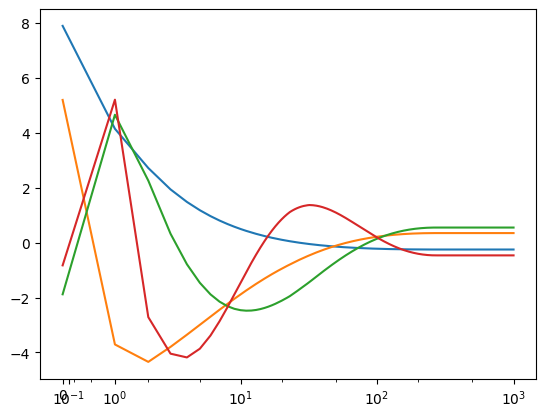

In [9]:
plt.plot(foo)
plt.xscale('asinh')
plt.show()

# Test sklearn transformer

In [10]:
def make_sl_pipeline(num_funcs):
    return make_pipeline(
        StrumLiouvilleTransformer(num_funcs=num_funcs, curvature_gamma=1.5),
        RidgeCV(alphas=np.geomspace(0.01, 10, 20))
    )

In [11]:
def make_kbins_pipeline(num_funcs, strategy: Literal['uniform', 'quantile', 'kmeans'] = 'uniform'):
    return make_pipeline(
        KBinsDiscretizer(n_bins=num_funcs, strategy=strategy),
        RidgeCV(alphas=np.geomspace(0.01, 10, 20))
    )

In [12]:
def make_bspline_pipeline(num_funcs, knots: Literal['uniform', 'quantile'] = 'uniform', degree=3):
    n_knots = num_funcs - degree + 1
    return make_pipeline(
        SplineTransformer(n_knots=n_knots, knots=knots, degree=degree, include_bias=False),
        RidgeCV(alphas=np.geomspace(0.01, 10, 20))
    )

In [13]:
def run_test(pipeline_fn):
    pipeline = pipeline_fn().fit(X_train, y_train)
    train_pred = pipeline.predict(X_train)
    test_pred = pipeline.predict(X_test)
    train_rmse = root_mean_squared_error(train_pred, y_train)
    test_rmse = root_mean_squared_error(test_pred, y_test)
    return train_rmse, test_rmse

In [14]:
options = {
    'strum-liouville': lambda n: make_sl_pipeline(n),
    'kbins-uniform': lambda n: make_kbins_pipeline(n, strategy='uniform'),
    'kbins-quantile': lambda n: make_kbins_pipeline(n, strategy='quantile'),
    'spline-uniform': lambda n: make_bspline_pipeline(n, knots='uniform'),
    'spline-quantile': lambda n: make_bspline_pipeline(n, knots='quantile')
}
ns = np.arange(5, 15).tolist()

In [15]:
results = []
for n in ns:
    for method, method_fn in options.items():
        train_rmse, test_rmse = run_test(lambda: method_fn(n))
        results.append((n, method, train_rmse, test_rmse))

In [16]:
result_df = pd.DataFrame(results, columns=['num_funcs', 'method', 'train_rmse', 'test_rmse'])
result_df.head(5)

,num_funcs,method,train_rmse,test_rmse
0,5,strum-liouville,0.103662,0.067447
1,5,kbins-uniform,0.674705,0.704333
2,5,kbins-quantile,0.242800,0.222718
3,5,spline-uniform,0.382876,0.374600
4,5,spline-quantile,0.330280,0.332725


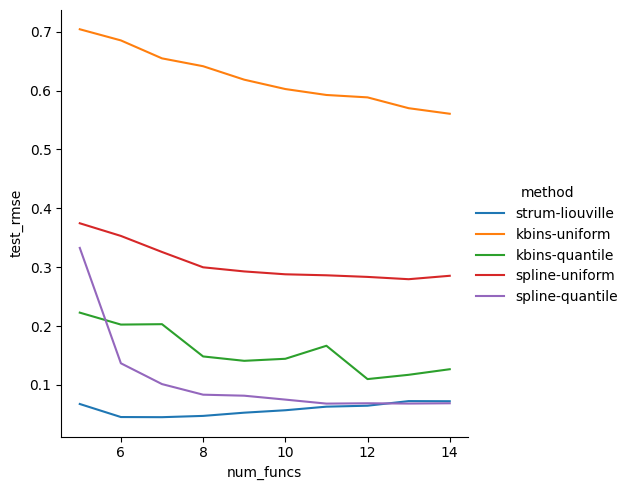

In [17]:
sns.relplot(data=result_df, x='num_funcs', y='test_rmse', hue='method', kind='line')